# Introduction

This notebook contains the code for the analysis presented in *Data-driven modelling and validation of aircraft inbound-stream at some major European airports* by Carlo Lancia (Leiden University) and Guglielmo Lulli (Lancaster University).
The manuscript shows how to construct point processes for the description of the inbound traffic at 8 important European airports.
The processes considered are a time-dependent Poisson process and Pre-Scheduled Random Arrivals.
These processes are constructed in a data-driven fashion and are compared on their capability of reproducing the average daily demand.

The dependencies are reported in the next two cells. Please note the requirements of `rpy2` and the following R-packages:

- `dgof`
- `DiscreteWeibull`
- `changepoint`

These R-packages are seemengly not availble through Anaconda standard or community channels, but can be successfully installe from within R via `install.packages`.

In [1]:
import atddm
import os
import pytz
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
from bisect import bisect, bisect_left
from datetime import time
from math import sqrt
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from statsmodels.tsa.stattools import adfuller
from constants import AIRPORTS, BEGDT, CODES, COLORS, ENDDT, TIMEZONES, TZONES

/Users/clancia/anaconda3/envs/interopy/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
r = robjects.r # instance of R
TRUE = robjects.BoolVector([True])
FALSE = robjects.BoolVector([False])
pandas2ri.activate() # on-the-fly conversion from Pandas to R dataframe

In [3]:
# Import R packages needed for the analysis
dgof = importr('dgof')
dweib = importr('DiscreteWeibull')
changepoint = importr('changepoint')

In [4]:
# Set style of graphics
sns.set(style='darkgrid', context='notebook')

## Load data and set constants

In [5]:
nairp = len(CODES)
CODES.sort() 
# sort ICAO codes alphabetically 
# in this way the order of airports will be fixed in the pictures

INTERVAL = 10 # in minutes
# binning parameter for the arrival series

ALPHA = 0.05 
# type-1 error
zval = stats.norm.ppf(1-ALPHA/2)
# critical z-value of the normal distribution

NPERIODS = 24*60/INTERVAL
# number of bins in a day

In [6]:
dd = atddm.load(subset=CODES)
# load data in a dictionary indexed by ICAO codes of arrival airport
# items are DataFrames
m3_bin = {}
# this dictionary will store aggregated arrival counts
# one Series per code, indexed by a DateTimeIndex with fixed frequency
# equal to INTERVALS minutes
# each entry stores the number of arrivals observed
# in the next INTERVALS minutes
daily = {}
# this dictionary will store statistics of the aggregated arrival counts
# one DataFrame per code

for code in CODES:
    indx = pd.date_range(start=BEGDT, end=ENDDT,
                         freq=str(INTERVAL)+'min',
                         tz=TZONES[code])
    m3_bin[code] = atddm.binarrivals(dd[code].M3_FL240,
                                     interval=INTERVAL,
                                     tz=TZONES[code])[indx].fillna(0)
    daily[code] = atddm.daily_avg(m3_bin[code], tz=TZONES[code])

In [7]:
ci = zval/sqrt(len(indx))
# half-size of confidence intervals for the autocorrelation function
# jack-knife formula from Chatfield's Analysis of Time Series (1980)

In [8]:
def rgbfy(key, colors=COLORS):
    """
    utility to transform colors 
    from format ([0,...,255], [0,...,255], [0,...,255])
    to format (r, g, b), where r, g, b are between 0 and 1
    
    input
    -----
    colors: dictionary of colors
    """
    return list(map(lambda x: x/255, colors[key]))

In [9]:
CWD = os.getcwd()
IMGFLDR = os.path.join(CWD, 'plots')
TABFLDR = os.path.join(CWD, 'tables')
# path to plots and tables folder
# it is not guaranteed to work, so hard coding the path might be required

## Data description

The analysis period covers the three summer months of 2016. This choice aimes at reducing the chance of weather-induced disruptions in the traffic data.

In [10]:
BEGDT = pd.Timestamp(BEGDT)
ENDDT = pd.Timestamp(ENDDT)
# Transform begin and end date as pandas.Timestamp
print('[{} - {}]'.format(BEGDT.date(), ENDDT.date()))

[2016-06-15 - 2016-09-14]


### Flight count

In [11]:
fcindx = [AIRPORTS[c] for c in CODES]
# full name of airports
fcindx = pd.Index(fcindx, name='airport name')

In [12]:
fc = pd.DataFrame(index=fcindx, data={
    'ICAO code': list(map(lambda s: s.upper(),
                             CODES)), 'sample size': [0]*len(CODES)
    })
# create DataFrame with count equal to 0

for code in CODES:
    name = AIRPORTS[code]
    tmp = (dd[code]['M3_FL240'] >= BEGDT) & (dd[code]['M3_FL240'] <= ENDDT)
    fc.loc[name, 'sample size'] = sum(tmp)
with open(os.path.join(TABFLDR, 'count_table.tex'), 'w') as ofile:
    ofile.write(fc.to_latex(column_format='lcr', escape=False))
fc

,ICAO code,sample size
airport name,,
Frankfurt am Main International Airport,EDDF,58167
London Gatwick Airport,EGKK,39746
London Heathrow Airport,EGLL,56716
Amsterdam Airport Schiphol,EHAM,63279
Madrid Barajas International Airport,LEMD,48162
Charles de Gaulle International Airport,LFPG,60122
Athens International Airport,LGAV,29503
Rome Fiumicino International Airport,LIRF,43333


### Average daily demand

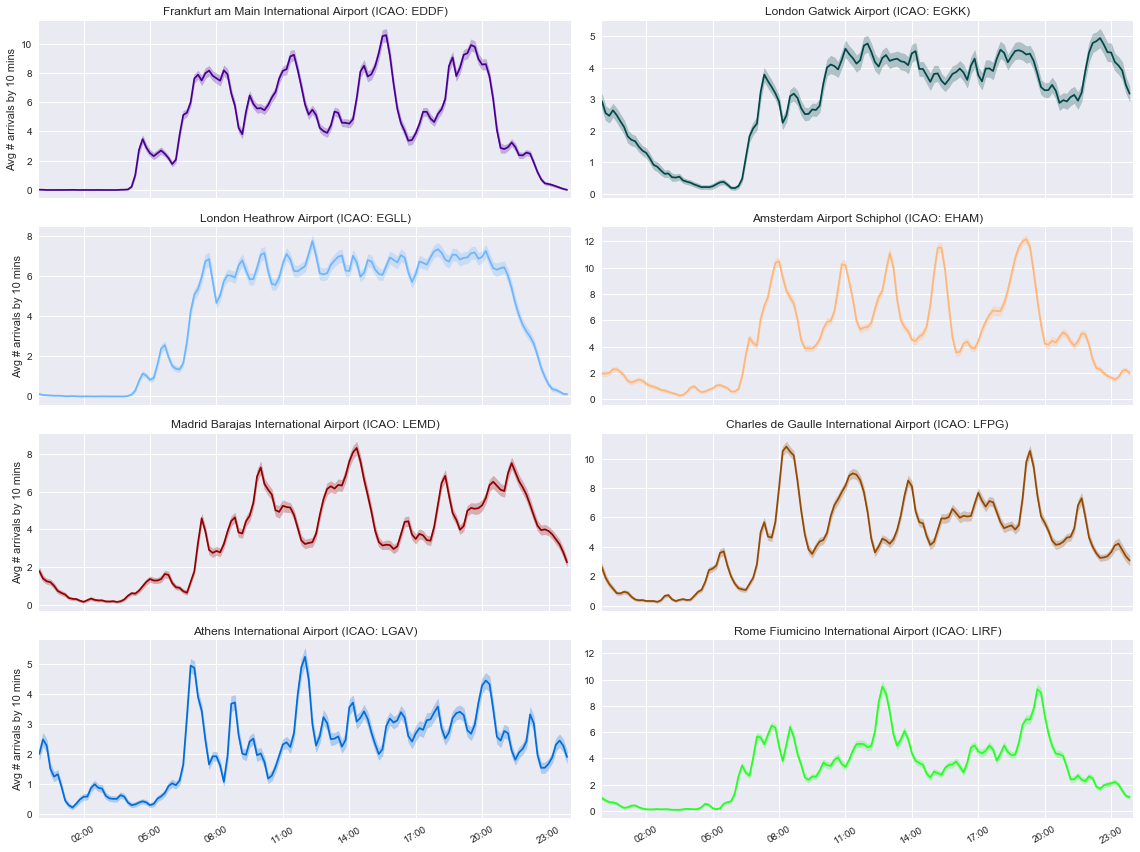

In [13]:
YMAX = 13 # upper limit of the y-scale
f, axes = plt.subplots(nairp//2, 2, sharex=True, sharey=False)
for ax, code in zip(axes.flatten(), CODES):
    df = daily[code] # DataFrame of daily arrivals
    # AVERAGE ARRIVALS
    freq = 60*df.index.freq.delta.components.hours +\
        df.index.freq.delta.components.minutes
    mu = df.mu # array of mean arrivals in each bin
    sem = df.stermn # array of standard error of the mean
    ax.plot(range(len(df)), mu, color=rgbfy(code))
    # plot the mean
    ax.fill_between(range(len(df)), mu - zval*sem, mu + zval*sem,
                    color=rgbfy(code), alpha=.25)
    # plot the confidence intervals
    times = [time(i, j).strftime('%H:%M') for i in range(24)
             for j in range(0, 60, freq)]
    # create list of time labels for a whole day every `freq` minutes
    # in total they are 24*60/freq labels
    xticks = [(2+3*i)*60//freq for i in range(8)]
    ax.set_title('{:s} (ICAO: {:s})'.format(AIRPORTS[code], code))
ax.set_ylim(-0.5, YMAX)
ax.set_xlim(0, 24*60//freq)
ax.set_xticks(xticks)
ax.set_xticklabels([times[i] for i in xticks])

for ax in axes[:, 0]:
    ax.set_ylabel('Avg # arrivals by {:d} mins'.format(INTERVAL))

for ax in axes[-1]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

f.set_size_inches(2*nairp, 1.5*nairp)
f.tight_layout()
f.savefig(os.path.join(IMGFLDR, 'AvgArrivals.png'), dpi=300, bbox_inches='tight')
plt.show()

# Interarrival times

In [14]:
# the analysis below is performed for time periods (t1, t2)
BEGTM_LOC = [pd.Timestamp('08:00:00'),
             pd.Timestamp('12:00:00'),
             pd.Timestamp('18:00:00')]
# list of starting times t1
ENDTM_LOC = [pd.Timestamp('09:30:00'),
             pd.Timestamp('13:30:00'),
             pd.Timestamp('19:30:00')]
# list of ending times t2
# both t1 and t2 are local times


def format_time_interval(t1, t2):
    # utility for formatting t1 and t2 in a single string
    return '{h1:02d}:{m1:02d}--{h2:02d}:{m2:02d}'.format(h1=t1.hour,
                                                         m1=t1.minute,
                                                         h2=t2.hour,
                                                         m2=t2.minute)

In [15]:
interarrivals = {}
# this dictionary will store the interarrivals time series
# this time series will be indexed with the time of each observed arrival
# its value will be the time lapse since the last observation
for code in CODES:
    tmp = dd[code]['M3_FL240'].sort_values()
    # fetch and order the time series
    indx = pd.DatetimeIndex(tmp[1:])
    # create new index by removing the first entry from the current one
    tz = pytz.timezone(TZONES[code])
    # set the timezone (times must be local!)
    indx = indx.tz_localize(pytz.utc).tz_convert(tz)
    # convert the index to local time
    tmp = (tmp.diff().dropna()/pd.Timedelta(1, 's')).tolist()
    # compute the difference in seconds between two consecutive arrival times
    # drop the first element
    interarrivals[code] = pd.DataFrame(data=tmp,
                                       index=indx,
                                       columns=[code])
    # create 
    interarrivals[code].index = interarrivals[code].index.tz_localize(None)
    # remove the timezone from the index
    # now times are local

In [16]:
# this cell creates an empty DataFrame indexed by
# level 0: time range for the interarrivals fit
# level 1: airport
# 
tmp = list(map(format_time_interval, BEGTM_LOC, ENDTM_LOC))
tmp = list(zip(sorted(tmp*len(CODES)), list(CODES)*len(BEGTM_LOC)))
indx = pd.MultiIndex.from_tuples(tmp, names=['time', 'airport'])
fttd_cols = ['q', 'beta', 'D', 'p', 'mean']
fitted_values = pd.DataFrame(index=indx,
                             columns=fttd_cols)
fitted_values = fitted_values.sort_index()
# the DataFrame will store the Maximum Likelihood Estimates
# of the parameter of the fitted distribution
# the Kolmogorov-Smirnov D-statistic and the corresponding p-value
# and the approximate mean of the fitted distribution

In [17]:
def fit_and_plot_interarrivals(t1, t2, interarrivals, fit_val, r=r, codes=CODES, colors=COLORS):
    # utility to fit the interarrivals between t1 and t2
    # against a discrete weibull Probability Mass Function
    # store the result of the fit
    # and produce QQ-plot and histograms of the interarrivals
    # against the fitted distribution
    
    timeinterval = format_time_interval(t1, t2)
    ## ia = {}
    f1, axes1 = plt.subplots(2, 4,
                             sharex=False,
                             sharey=False,
                             figsize=(22, 10))
    f2, axes2 = plt.subplots(2, 4,
                             sharex=False,
                             sharey=False,
                             figsize=(16, 9))
    for code, ax1, ax2 in zip(CODES, axes1.flatten(), axes2.flatten()):
        k = rgbfy(code)
        # pick the color of the airport
        tmp = interarrivals[code].loc[BEGDT:ENDDT]
        tmp = tmp.between_time(t1.time(), t2.time())
        # slice the interarrivals between t1 and t2
        ## ia[code] = np.array(tmp).flatten()
        ## yy = ia[code]
        yy = np.array(tmp).flatten()

        fit = dweib.estdweibull(yy, 'ML', zero=TRUE)
        # fit the discrete Weibull
        # zero=TRUE is required to have 0 in the support of the PMF
        fit_val.loc[(timeinterval, code), fttd_cols[:2]] = np.array(fit).round(4)
        # store the parameters of the Weibull
        qqx = r.seq(0, max(yy))
        ffx = r.stepfun(qqx, r.c(dweib.pdweibull(qqx,
                                                 fit[0],
                                                 fit[1],
                                                 zero=TRUE), 1))
        # create a step function with the cumulative probability of the fitted Weibull
        # this is required to perform the KS-test
        ks = dgof.ks_test(yy, ffx)
        tmp = [ks.rx2('statistic'), ks.rx2('p.value')]
        fit_val.loc[(timeinterval, code), fttd_cols[2:4]] = np.array(tmp).flatten()
        # perform the KS goodness of fit test amd store the results
        xx = r.seq(0, 2500)
        probs = dweib.ddweibull(xx, fit[0], fit[1], zero=TRUE)
        fit_val.loc[(timeinterval, code), fttd_cols[4]] = sum(np.array(xx) * np.array(probs))
        # compute empirically the mean on a very long interval
        # the distribution decays very fast so this is safe

        n, bins, patches = ax2.hist(yy,
                                    bins=range(int(min(yy)),
                                               int(max(yy)+1),
                                               30),
                                    normed=1,
                                    facecolor=k,
                                    alpha=0.5)
        y = np.array(dweib.ddweibull(bins, fit[0], fit[1], zero=TRUE))
        l = ax2.plot(bins, y, 'k--', linewidth=1)
        ax2.set_xlabel('Time (sec)')
        ax2.set_title('{:s}: q = {:.3f}, beta = {:.3f}'.format(code,
                                                               fit[0],
                                                               fit[1]))
        # make an histogram of the interarrivals and overlay the fitted distribution
        
        qq = np.arange(len(yy))/(len(yy)+1.)
        yy = np.percentile(yy, 100*qq)
        # empicical quantiles
        xx = np.array(dweib.qdweibull(qq, fit[0], fit[1], zero=TRUE))
        # theoretical quantiles
        ax1.scatter(xx, yy, color=k, s=5, alpha=0.5)
        ax1.plot(xx, xx, c='k', lw=.75, ls='--')
        ax1.axis('square')
        ax1.set_xlabel('Theoretical quantiles')
        ax1.set_ylabel('Empirical quantiles')
        ax1.set_title('{:s}: q = {:.3f}, beta = {:.3f}'.format(code,
                                                               fit[0],
                                                               fit[1]))        
        # make a QQ-plot and overlay a 45-degrees line
        
    return (f1, axes1, f2, axes2)

## Period 08:00 - 09:30 local time

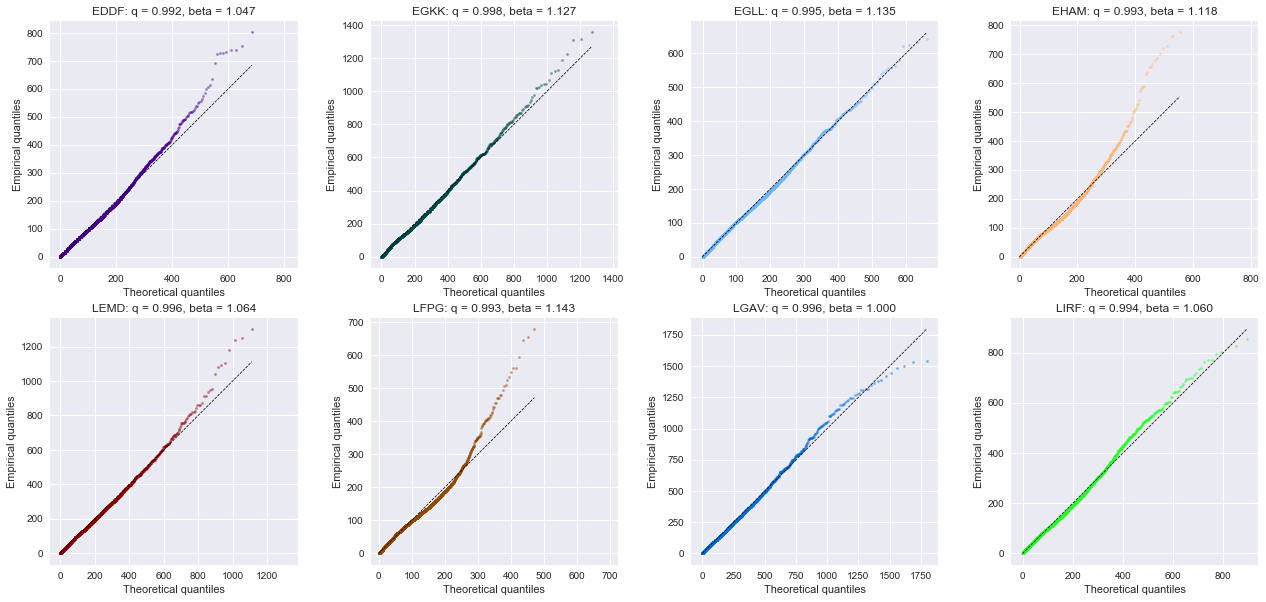

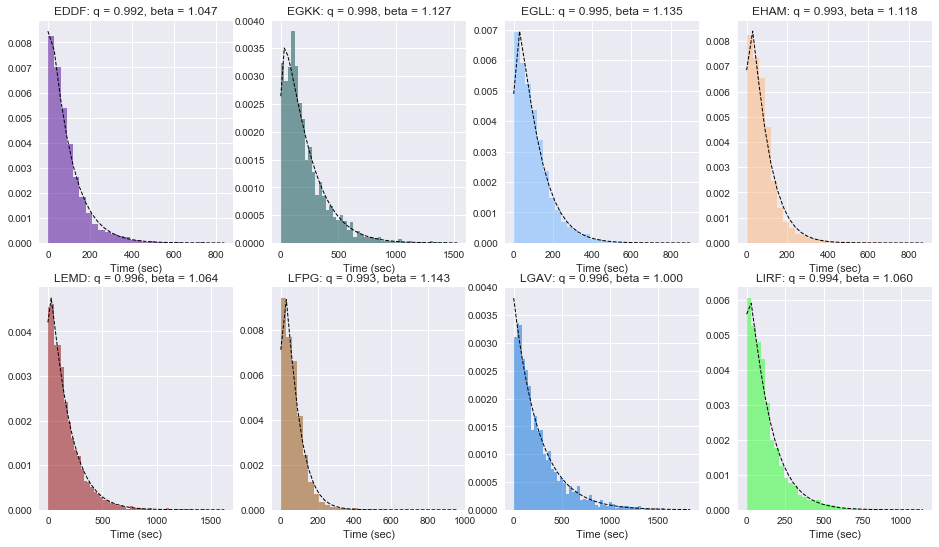

In [18]:
t1 = BEGTM_LOC[0]
t2 = ENDTM_LOC[0]
f1, axes1, f2, axes2 = fit_and_plot_interarrivals(t1, t2, interarrivals, fitted_values)
f1.savefig(os.path.join(IMGFLDR, 'IA_qqplot0800-0930.png'), dpi=300, bbox_inches='tight')
f2.savefig(os.path.join(IMGFLDR, 'IA_histgr0800-0930.png'), dpi=300, bbox_inches='tight')
plt.show()

## Period 12:00 - 13:30 local time

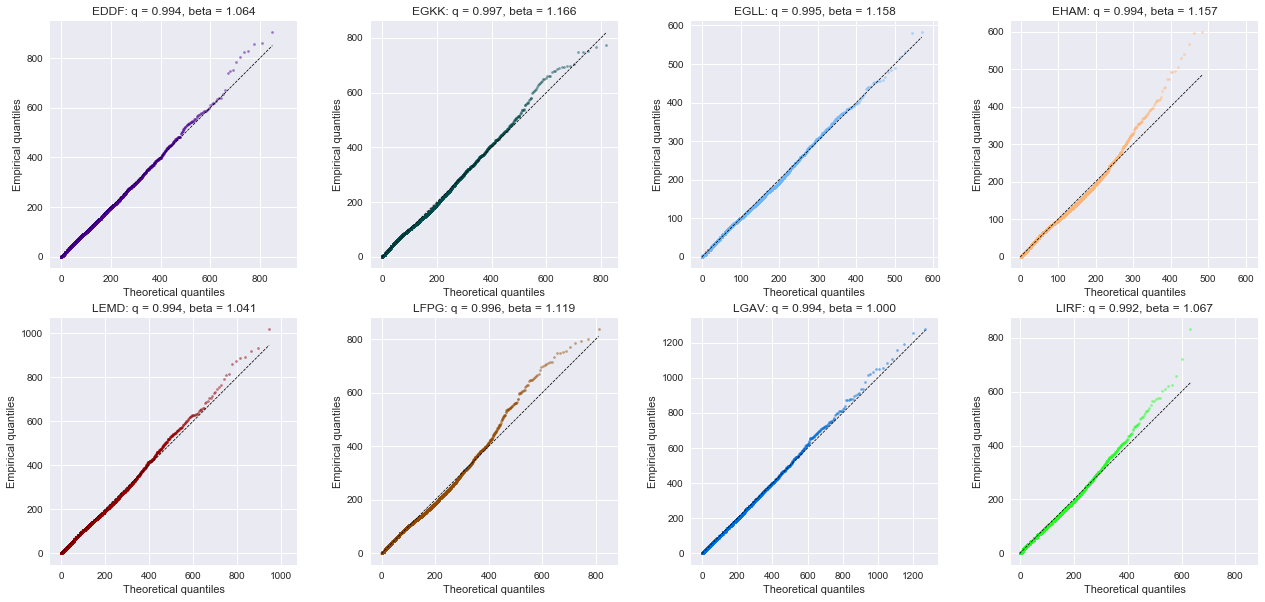

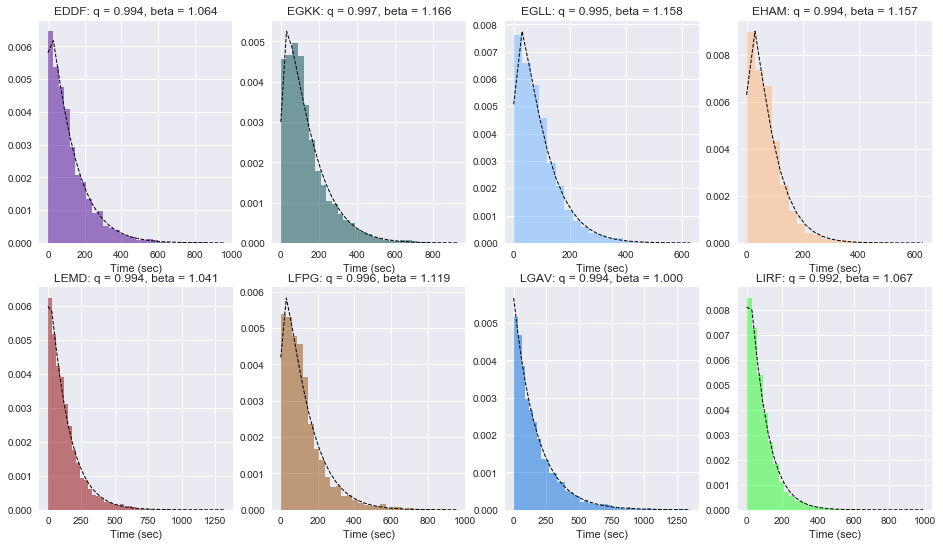

In [19]:
t1 = BEGTM_LOC[1]
t2 = ENDTM_LOC[1]
f1, axes1, f2, axes2 = fit_and_plot_interarrivals(t1, t2, interarrivals, fitted_values)
f1.savefig(os.path.join(IMGFLDR, 'IA_qqplot1200-1330.png'), dpi=300, bbox_inches='tight')
f2.savefig(os.path.join(IMGFLDR, 'IA_histgr1200-1330.png'), dpi=300, bbox_inches='tight')
plt.show()

## Period 18:00 - 19:30 local time

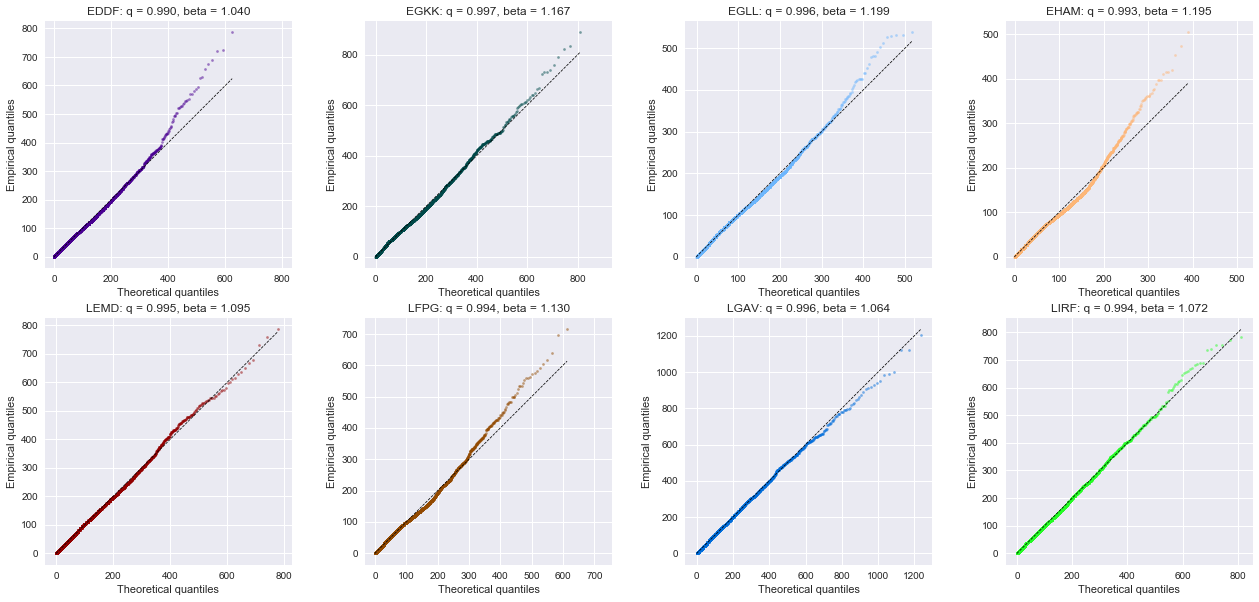

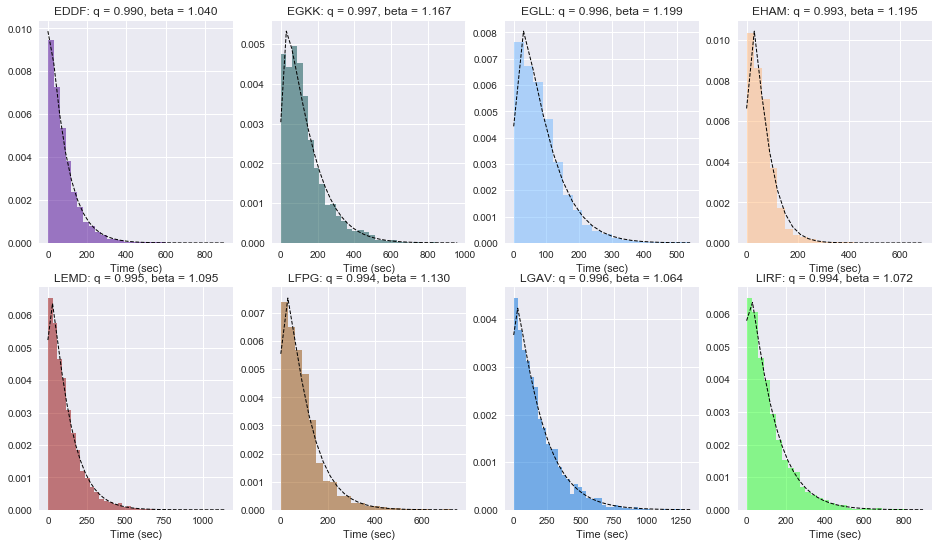

In [20]:
t1 = BEGTM_LOC[2]
t2 = ENDTM_LOC[2]
f1, axes1, f2, axes2 = fit_and_plot_interarrivals(t1, t2, interarrivals, fitted_values)
f1.savefig(os.path.join(IMGFLDR, 'IA_qqplot1800-1930.png'), dpi=300, bbox_inches='tight')
f2.savefig(os.path.join(IMGFLDR, 'IA_histgr1800-1930.png'), dpi=300, bbox_inches='tight')
plt.show()

## Overview

In [21]:
def ifelse_formatter(x):
    return formatter_float_n_digits(x, 2) if x >= 0.01 else '<0.01'


def formatter_float_n_digits(x, n):
    return '{x:.{n}f}'.format(x=x, n=n)


def ff3(x):
    return formatter_float_n_digits(x, 3)

In [22]:
with open(os.path.join(TABFLDR, 'fit_table.tex'), 'w') as ofile:
    # format table with fitted values and export in LaTeX
    fitted_values['p'] = fitted_values['p'].apply(ifelse_formatter)
    newcols = ['$q$', '$\\beta$', '$D$-stat.', '$p$-value', 'mean']
    rename_dict = dict(zip(fttd_cols, newcols))
    foo = fitted_values.rename(columns=rename_dict)
    foo = foo.reset_index()
    foo['airport'] = foo['airport'].apply(lambda s: '\\airp{' + s.lower() + '}')
    foo = foo.set_index(['time', 'airport'])
    ofile.write(foo.to_latex(column_format='llrrrrr',
                            escape=False,
                            columns=newcols,
                            float_format=ff3))
fitted_values

q    beta          D      p     mean
time         airport                                           
08:00--09:30 EDDF     0.9916  1.0465   0.019563   0.03   93.131
             EGKK     0.9978  1.1273  0.0319529   0.02  214.506
             EGLL     0.9951  1.1346  0.0239924  <0.01  103.273
             EHAM     0.9932  1.1176  0.0329367  <0.01  82.2092
             LEMD     0.9958  1.0639  0.0191429   0.21   166.54
             LFPG     0.9929  1.1434  0.0327649  <0.01  71.3356
             LGAV     0.9962       1  0.0205498   0.40  261.533
             LIRF     0.9944  1.0595  0.0234674   0.03  129.793
12:00--13:30 EDDF     0.9942  1.0636   0.018467   0.13  122.668
             EGKK      0.997  1.1658  0.0332991  <0.01  137.588
             EGLL     0.9949  1.1582  0.0258954  <0.01  90.2623
             EHAM     0.9937  1.1575  0.0348448  <0.01  74.9903
             LEMD      0.994  1.0414  0.0159557   0.29  133.073
             LFPG     0.9958  1.1192  0.0274501  <0.01  127.154
             LGAV     0.9943       1  0.0129628   0.74  175.291
             LIRF     0.9919  1.0667  0.0209261   0.01    88.12
18:00--19:30 EDDF     0.9901  1.0404  0.0151295   0.12  82.4655
             EGKK      0.997  1.1668  0.0344259  <0.01  135.505
             EGLL     0.9956  1.1991  0.0312039  <0.01  85.6791
             EHAM     0.9934  1.1954  0.0328509  <0.01  61.8951
             LEMD     0.9948  1.0947  0.0133126   0.43  116.381
             LFPG     0.9945  1.1304  0.0270682  <0.01  93.9814
             LGAV     0.9963  1.0639  0.0130277   0.77   189.09
             LIRF     0.9942  1.0721  0.0162099   0.21  117.987

# Time-series analysis

## Autocorrelations

### 1st order differenced time series

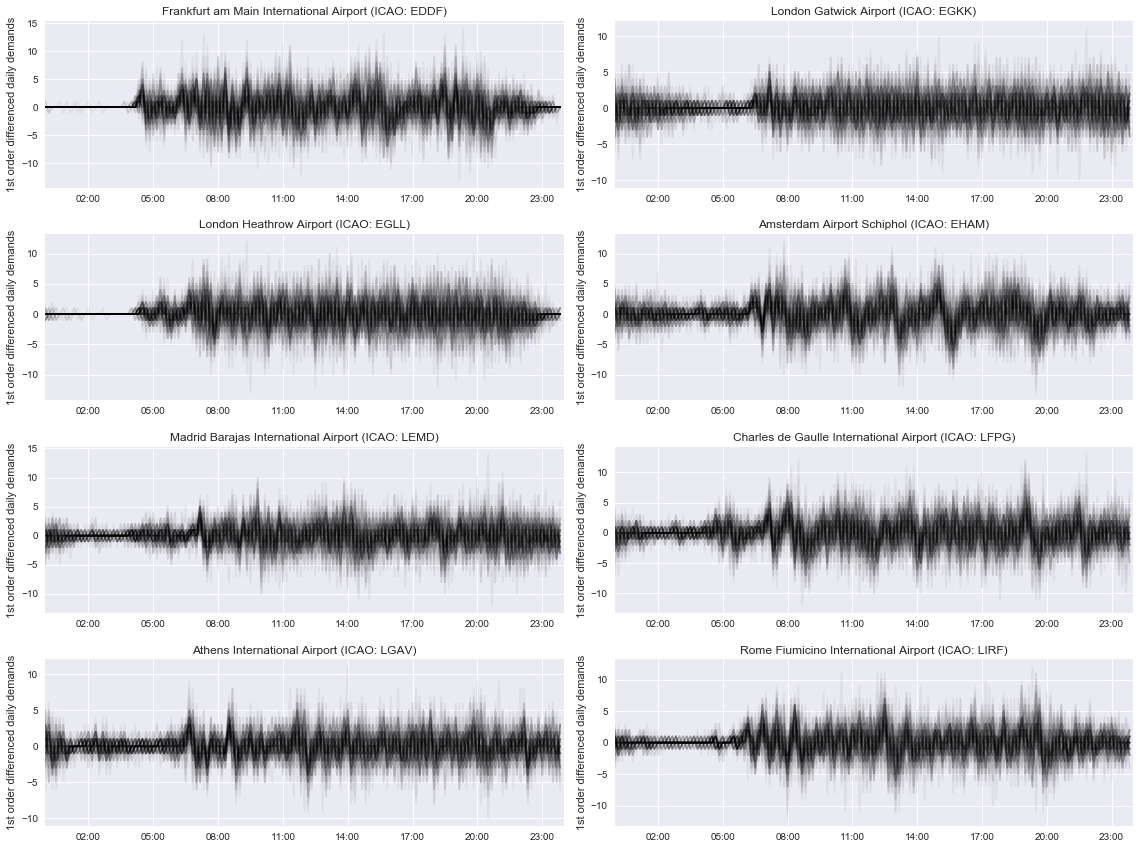

In [23]:
f, axes = plt.subplots(nairp//2, 2, sharey=False)
for ax, code in zip(axes.flatten(), CODES):
    ts = m3_bin[code].fillna(0)
    # get the aggregated time series of observed number of arrivals
    ts = ts.diff().dropna()
    # take first-order differences and drop the first element
    freq = 60*ts.index.freq.delta.components.hours +\
        ts.index.freq.delta.components.minutes
    day0 = ts.index[0]
    # this is the first time interval in the Index of ts 
    days = int(len(ts)/(24*60/freq))
    begdays = [day0 + pd.Timedelta(i, 'D') for i in range(0, days)]
    # the first time interval of periods of 24 hours
    enddays = [d + pd.Timedelta(1, 'D') - pd.Timedelta(INTERVAL, 'm')
               for d in begdays]
    # last time interval in these periods of 24 hours
    for bd, ed in zip(begdays, enddays):
        ax.plot(range(24*60//freq), ts.loc[bd:ed], color='k', alpha=0.05)
        # slice ts on the periods of 24 hours defined above 
        # and plot with very light transparency
    times = [time(i, j).strftime('%H:%M') for i in range(24)
             for j in range(0, 60, freq)]
    xticks = [(2+3*i)*60//freq for i in range(8)]
    ax.set_xlim(0, 24*60//freq)
    ax.set_xticks(xticks)
    ax.set_xticklabels([times[i] for i in xticks])
    ax.set_ylabel('1st order differenced daily demands')
    ax.set_title('{:s} (ICAO: {:s})'.format(AIRPORTS[code], code))

f.set_size_inches(2*nairp, 1.5*nairp)
f.tight_layout()
f.savefig(os.path.join(IMGFLDR, 'DailyDemand.png'), dpi=300, bbox_inches='tight')
plt.show()

### Autocorrelations

In [24]:
# empty DataFrame to store the results of the following cell
lag1acf = pd.Series(index=CODES)
adftest = pd.DataFrame(index=CODES, columns=['adf', 'adf*', 'p-val'])

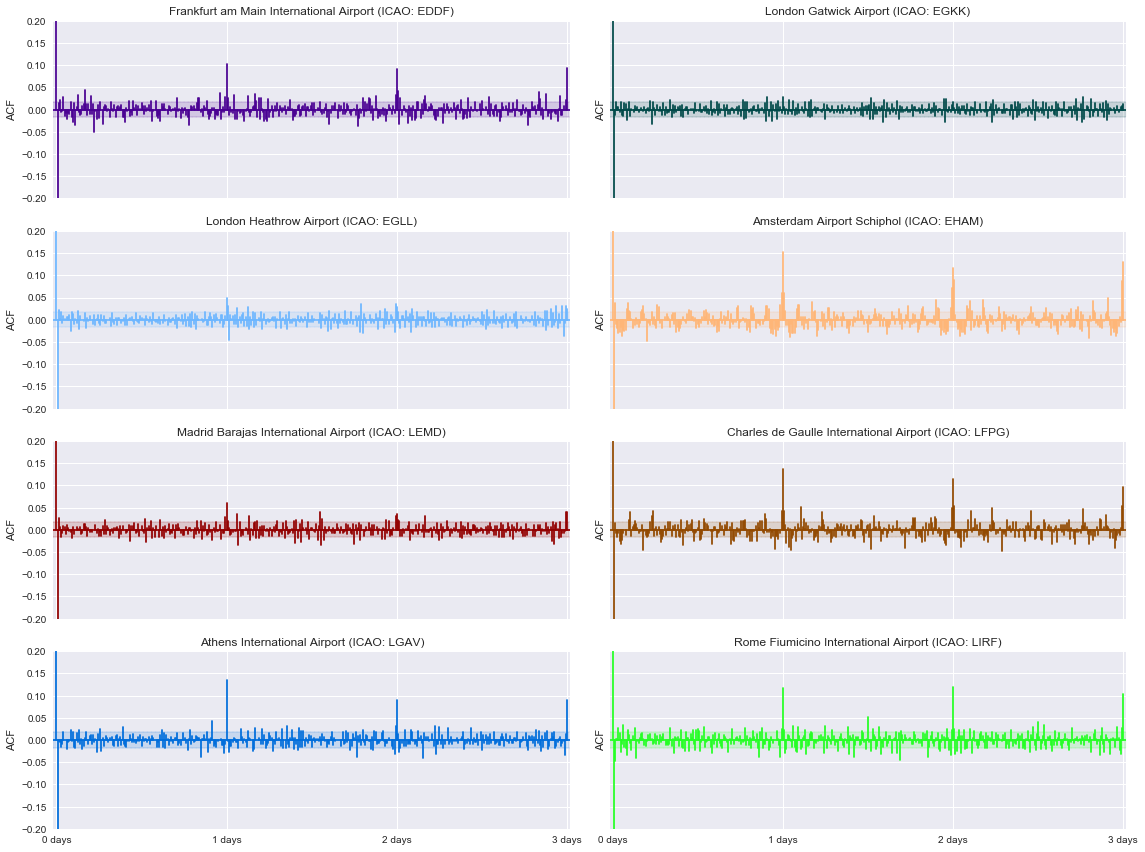

In [25]:
f, axes = plt.subplots(nairp//2, 2, sharex=True, sharey=True)

for ax, code in zip(axes.flatten(), CODES):
    ts = m3_bin[code].fillna(0)
    # get the aggregated time series of observed number of arrivals
    freq = 60*ts.index.freq.delta.components.hours +\
        ts.index.freq.delta.components.minutes
    ndays = 3
    lagmax = ndays*24*60//freq
    # maximum number of lags corresponding to 3 days
    ts = ts.diff().dropna()
    # take first-order differences and drop first element
    test = adfuller(ts[:24*60//freq], regression='nc')
    # test for stationariety in the first day
    adftest.loc[code, :] = [test[0], test[4]['1%'], test[1]]
    # store results of test
    lag1acf.loc[code] = ts[:24*60//freq].autocorr(lag=1)
    # store the value of the lag-1 autocorrelation
    # this is needed because the plot below will cap the y-axis
    # between -0.2 and 0.2, but this correlation is much larger
    autocorr = [ts.autocorr(lag=i) for i in range(lagmax+1)]
    # compute autocorrelation function
    ax.fill_between(range(-3, lagmax+3), -ci, ci, color=rgbfy(code), alpha=.15)
    ax.axhline(ci, color=rgbfy(code), lw=0.25, ls='--')
    ax.axhline(-ci, color=rgbfy(code), lw=0.25, ls='--')
    ax.axhline(0, color=rgbfy(code))
    markerline, stemlines, baseline = ax.stem(range(len(autocorr)),
                                              autocorr,
                                              markerfmt=' ',
                                              basefmt=' ')
    # plot autocorrelation function and confidence intervals
    plt.setp(stemlines, 'color', rgbfy(code))
    ax.set_ylabel('ACF')
    ax.set_title('{:s} (ICAO: {:s})'.format(AIRPORTS[code], code))
ax.set_xlim(-2.5, lagmax+2.5)
ax.set_ylim(-0.2, 0.2)
ndays += 1
ax.set_xticks([i*24*60//freq for i in range(ndays)])
ax.set_xticklabels(['{:d} days'.format(i) for i in range(ndays)])

f.set_size_inches(2*nairp, 1.5*nairp)
f.tight_layout()
f.savefig(os.path.join(IMGFLDR, 'Autocorr.png'), dpi=300, bbox_inches='tight')
plt.show()

In [26]:
with open(os.path.join(TABFLDR, 'lag1acf.tex'), 'w') as ofile:
    ofile.write(lag1acf.to_latex())
lag1acf
# value of lag-1 autocorrelation

EDDF   -0.446755
EGKK   -0.525782
EGLL   -0.439940
EHAM   -0.359222
LEMD   -0.466047
LFPG   -0.415393
LGAV   -0.479257
LIRF   -0.535114
dtype: float64

In [27]:
with open(os.path.join(TABFLDR, 'adftest.tex'), 'w') as ofile:
    ofile.write(adftest.to_latex())
adftest
# results of Dickey-Fuller test for stationariety

,adf,adf*,p-val
EDDF,-14.6971,-2.58166,2.87371e-26
EGKK,-9.02414,-2.58201,1.51866e-15
EGLL,-11.492,-2.58178,7.10354e-21
EHAM,-11.0553,-2.58166,5.51914e-20
LEMD,-12.7711,-2.58178,2.71072e-23
LFPG,-14.976,-2.58166,1.27347e-26
LGAV,-6.22863,-2.58276,3.03741e-09
LIRF,-12.5793,-2.58166,5.96601e-23


## Time-frequency analysis

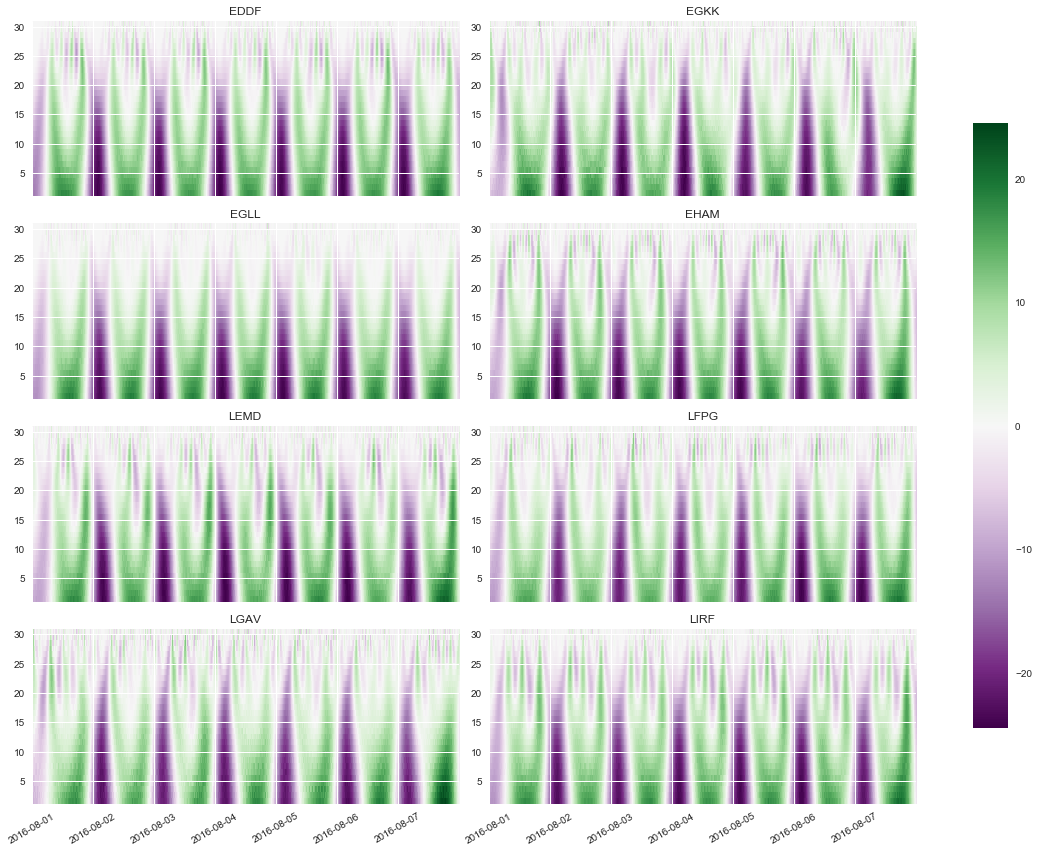

In [28]:
# time-continuous wavelet analysis 
# to highlight the presence of a mode with daily periodicity
# for convenience the analysis is performed on a single week
f, axes = plt.subplots(nairp//2, 2, sharex=True)
widths = np.arange(1, 31)
weekstr = '2016-08-01'
weekend = '2016-08-07'
xticks = [144*i for i in range(7)]
xticklabels = ['2016-08-01', '2016-08-02', '2016-08-03', '2016-08-04',
               '2016-08-05', '2016-08-06', '2016-08-07']

for ax, code in zip(axes.flatten(), CODES):
    df = m3_bin[code].loc['2016-08-01':'2016-08-07']
    cwtmatr, freqs = pywt.cwt(df, widths, 'mexh')
    im = ax.imshow(cwtmatr, extent=[0, len(df), 1, 31], cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=30)
    ax.set_title(code)

f.set_size_inches(2*nairp, 1.5*nairp)
f.tight_layout()
f.savefig(os.path.join(IMGFLDR, 'ContWavltTrasf.png'), dpi=300, bbox_inches='tight')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax)
plt.show()

# Data-driven Poisson model

In [29]:
II = np.repeat(list(range(nairp//2)), 2)
JJ = [0, 1]*(nairp//2)
# plotting parameters

HPARMS = pd.DataFrame.from_dict({
    'EDDF': [0.2, 15],
    'EGKK': [0.25, 21],
    'EGLL': [0.2, 15],
    'EHAM': [0.17, 15],
    'LEMD': [0.16, 17],
    'LFPG': [0.15, 15],
    'LGAV': [0.21, 21],
    'LIRF': [0.185, 17],
    }, orient='index')
HPARMS.columns = ['eps', 'msample']
# airport specific hyperparameters for DBSCAN

icount = 0
detected_lambdas = pd.DataFrame(columns=['icao', 'time', 'lambda'])
# this DataFrame will store the parameters 
# of the identified time-dependent Poisson process

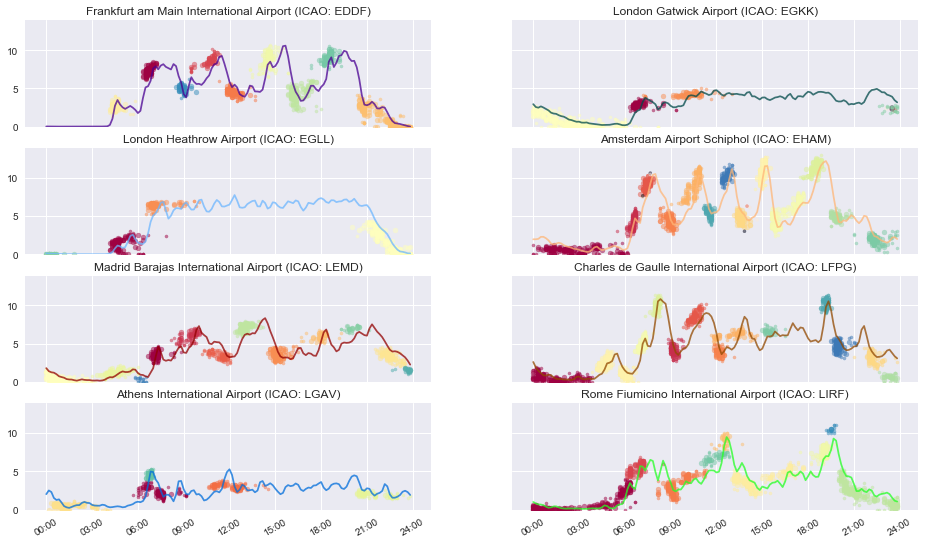

In [30]:
f, axes = plt.subplots(nairp//2, 2, sharex=True, sharey=True, figsize=(16,9))

for code, i, j in zip(CODES, II, JJ):
    ####################################################################
    indx = pd.date_range(start=BEGDT, end=ENDDT,
                         freq=str(INTERVAL)+'min', tz=TZONES[code])
    binned = atddm.binarrivals(dd[code].M3_FL240,
                               interval=INTERVAL, tz=TZONES[code])[indx]
    daily = atddm.daily_avg(binned, tz=TZONES[code])
    # Not really needed because this data has been already loaded
    ####################################################################

    freq = binned.index.freq.delta.components.minutes +\
        binned.index.freq.delta.components.hours * 60
    periods = int(TIMEZONES[code]/pd.Timedelta(freq, 'm'))

    values = changepoint.cpt_meanvar(binned.fillna(0).astype(int),
                                     test_stat='Poisson',
                                     method='PELT',
                                     penalty='AIC')
    # detect changes in either mean of variance under the null of Poisson arrivals
    # the dection is based on PELT algorithm
    # with penalty fucntion based on Akaike Information Criterion
    pars = np.array(values.do_slot('param.est')).flatten()
    # stores detected Poisson parameter in a numpy array
    chng = (np.array(changepoint.cpts(values)).flatten()) % NPERIODS
    # stores the time of the day when each change was detected
    # times are stored as a multiple of the aggregation INTERVAL since midnight

    ax = axes[i, j]
    ax.plot(
        range(len(daily)),
        daily.mu,
        color=rgbfy(code),
        alpha=.75
    )
    # plot the average daily demand

    if len(chng) == 0:
        ax.set_title('{:s}: No changepoint detected'.format(code))
        continue

    
    # last changepoint is fully discarded
    # the first parameter is not associated to any change
    X = np.vstack((chng[:-1], pars[1:-1])).T
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    # create 2-column matrix with Poisson parameters (lambda)
    # and corresponding time of detected changepoint
    # then shift to zero mean and scale to unit variance 
    db = DBSCAN(eps=HPARMS.loc[code, 'eps'],
                min_samples=HPARMS.loc[code, 'msample'],
                n_jobs=2)
    db = db.fit(X)
    # cluster (t, lambda) points via DBSCAN
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # cluster labels and mask for plotting core and non-core points

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # number of clusters in labels, ignoring noise if present
    unique_labels = set(labels)
    
    XX = scaler.inverse_transform(X)
    kolors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, kolors):
        alpha = 0.5
        if k == -1:
            # black used for noise
            col = 'k'
            alpha = 0.25
            # comment the following line to plot noise
            continue

        class_member_mask = (labels == k)

        if k >= 0:
            centroid = XX[class_member_mask].mean(axis=0)
            detctime = '{h:02d}:{m:02d} UTC+{tz:02d}'.format(
                    h=int(centroid[0]*INTERVAL // 60),
                    m=int(centroid[0]*INTERVAL % 60),
                    tz=int(TIMEZONES[code]/pd.Timedelta(1, 'h')))
            t_hat = '{:.04f} aircraft/min'.format(round(centroid[1]/INTERVAL,
                                                  ndigits=4))
            detected_lambdas.loc[icount] = [code, detctime, t_hat]
            # for each cluster compute centroids and store them
            icount += 1

        xy = XX[class_member_mask & core_samples_mask]
        ax.scatter(xy[:, 0], xy[:, 1], marker='o', c=col, s=25, alpha=alpha)

        xy = XX[class_member_mask & ~core_samples_mask]

        ax.scatter(xy[:, 0], xy[:, 1], marker='o', c=col, s=10, alpha=alpha)
        ax.set_title('{:s} (ICAO: {:s})'.format(AIRPORTS[code], code))

ax.set_xticks([int(i*NPERIODS/8) for i in range(9)])
ax.set_xticklabels(['{:02d}:{:02d}'.format(t*INTERVAL//60, t*INTERVAL % 60)
                    for t in ax.get_xticks()])
ax.set_ylim(bottom=0)


for ax in axes[-1]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
f.savefig(os.path.join(IMGFLDR, 'DDPoisson.png'), dpi=300, bbox_inches='tight')
plt.show()

In [31]:
detected_lambdas = detected_lambdas.set_index(['icao', 'time'])
detected_lambdas = detected_lambdas.sort_index()
with open(os.path.join(TABFLDR, 'poisson_rates.tex'), 'w') as ofile:
    ofile.write(detected_lambdas.to_latex(column_format='ccr', escape=False))

# Poisson vs. Pre-Scheduled Random Arrivals

## Average daily demand from data and simulations

In [32]:
NX = 2
NY = nairp//2
SX = 24
SY = 10
MS = 30
LW = 2
# plotting parameters
ALPHA = 0.05 
# type-1 error
zval = stats.norm.ppf(1-ALPHA/2) 
# Critical z-value of the normal distribution

freq = INTERVAL
times = [time(i, j).strftime('%H:%M') for i in range(24)
         for j in range(0, 60, freq)]
xticks = [(2+3*i)*60//freq for i in range(8)]


def timetofloat(t, freq):
    # transforms a pandas.Timestamp in the corresponding 
    # number of intervals of length freq since midnight
    return t.time().hour*60//freq + t.time().minute/freq


def rho2z(r):
    # asymptotic normal approximation of Pearson's rho
    return np.log((1+r)/(1-r))


def z2rho(z):
    # inverse of the previous transformation
    return (np.exp(2*z)-1)/(np.exp(2*z)+1)


def axtitle(code):
    # small utility to compose the title of a subplot
    return '{:s} (ICAO: {:s})'.format(AIRPORTS[code], code)

In [33]:
midnight = pd.Timestamp('00:00:00')
sta_times = [midnight + pd.Timedelta(t*60, unit='s')
             for t in range(0, 24*60, INTERVAL)]
end_times = [midnight + pd.Timedelta((INTERVAL+t)*60-1, unit='s')
             for t in range(0, 24*60, INTERVAL)]
slices = [(a.time(), b.time()) for a, b in zip(sta_times, end_times)]
# forms tuples of times of the form
# (00:00:00, 00:09:59), (00:10:00, 00:19:59) and so on

In [34]:
m3_bin = {}
# will store series of aggregated observed arrivals
# these are arrivals according to the 'current' flight plan
m1_bin = {}
# will store series of aggregated planned arrivals
# these are arrivals according to the 'regulated' flight plan
psra_bin = {}
# will store series of aggregated simulated arrivals
# the simulation model for the unaggregated arrivals is
# t_i = M1_i + xi
# where
# t_i is the simulated ith arrival time
# M1_i is the ith regulated arrival time
# M3_i is the ith current arrival time
# xi is drawn with replacement from the empirical distribution of M3_i - M1_i

for code in CODES:
    df = dd[code]
    tz = TZONES[code]
    indx = pd.date_range(start=BEGDT, end=ENDDT,
                         freq=str(INTERVAL)+'min',
                         tz=tz)
    m3_bin[code] = atddm.binarrivals(df.M3_FL240,
                                     interval=INTERVAL,
                                     tz=tz)[indx].fillna(0)
    m3_bin[code].index = m3_bin[code].index.tz_localize(None)
    m1_bin[code] = atddm.binarrivals(df.M1_FL240,
                                     interval=INTERVAL,
                                     tz=tz)[indx].fillna(0)
    m1_bin[code].index = m1_bin[code].index.tz_localize(None)
    tmp = df.M1_FL240 + np.array(df.delay.sample(n=len(df), replace=True))
    psra_bin[code] = atddm.binarrivals(tmp,
                                       interval=INTERVAL,
                                       tz=tz)[indx].fillna(0)
    psra_bin[code].index = psra_bin[code].index.tz_localize(None)

In [35]:
daily = {}
daily_psra = {}
for code in CODES:
    tz = TZONES[code]
    daily[code] = atddm.daily_avg(m3_bin[code], tz=tz)
    daily[code].index = daily[code].index.tz_localize(None)
    daily_psra[code] = atddm.daily_avg(psra_bin[code], tz=tz)
    daily_psra[code].index = daily_psra[code].index.tz_localize(None)
# average daily demand from observed and simulated data
# Poisson arrivals are not simulated,
# because the demand is obviously piece-wise constant 

In [36]:
airp_parm = detected_lambdas.reset_index()
airp_parm['time'] = airp_parm['time'].apply(lambda x:
                                            pd.Timestamp(x.split(' ')[0]))
airp_parm['lambda'] = airp_parm['lambda'].apply(lambda x:
                                                float(x.split(' ')[0]))
# strip timezone and unit measure form t and lambda
airp_parm = {key: list(zip(df['lambda'], df['time']))
             for key, df in airp_parm.groupby('icao')}
# transform the DataFrame in a dictionary
# that maps each airport onto a list of (lambda, t)

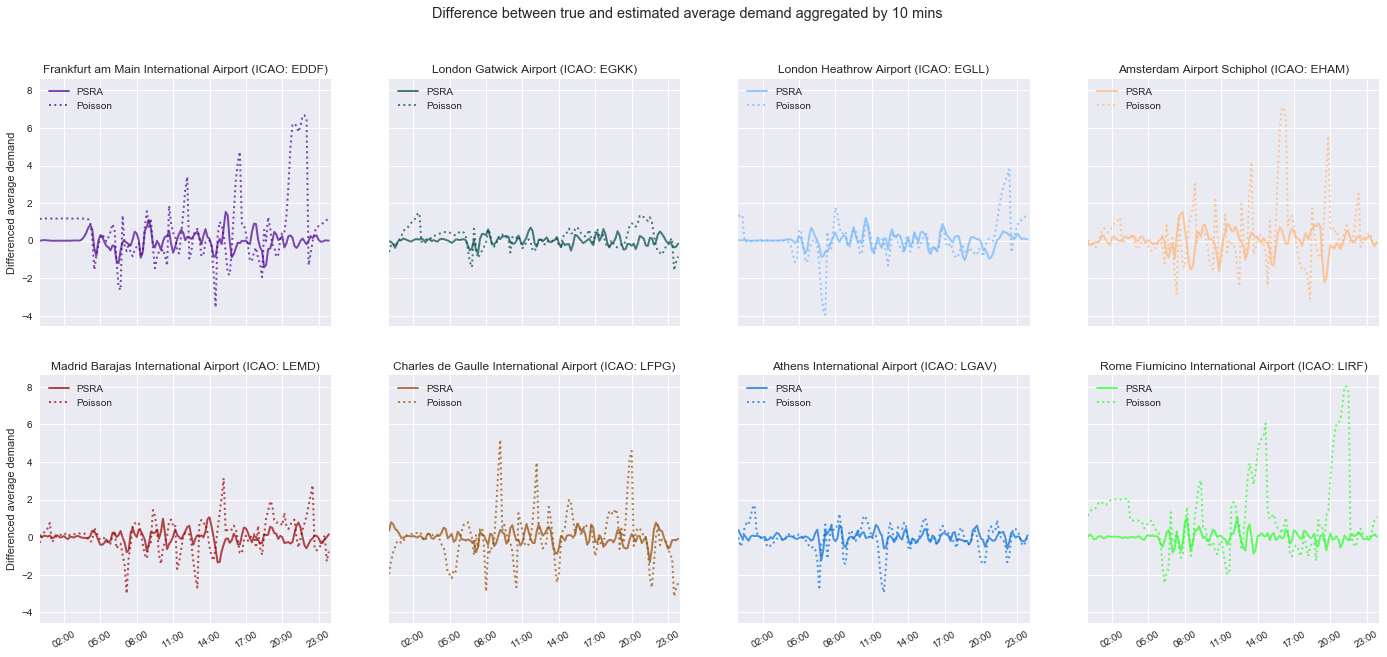

In [37]:
# plot point estimates of average demand according to
# current flight plan (M3), PSRA model, and Poisson model
f, axes = plt.subplots(NX, NY, sharex=True, sharey=True, figsize=(SX, SY))

for ax, code in zip(axes.flatten(), CODES):
    kolor = rgbfy(code)
    xx = range(24*60//freq)
    datamu = daily[code]['mu']
    ax.plot(xx, daily_psra[code]['mu'] - datamu,
            c=kolor,
            linestyle='-',
            linewidth=LW,
            alpha=0.7,
            label='PSRA')
    
    xval = [0] + [timetofloat(tpl[1], freq) for tpl in airp_parm[code]] +\
        [24*60//freq]
    yval = [tpl[0]*freq for tpl in airp_parm[code]]
    yval = [yval[-1], yval[-1]] + yval
    # this is needed to plot the demamd estimated by Poisson
    # correctly at the beginning and the end of the day
    # and in such a way that the process is 24-hour periodic
    yy = [yval[bisect(xval, x)] for x in xx]
    
    ax.plot(xx, yy - datamu, 
            color=kolor,
            linestyle=':',
            linewidth=LW,
            alpha=0.7,
            label='Poisson')
    legend = ax.legend(loc='upper left')
    ax.set_title(axtitle(code))
ax.set_xlim(0, 24*60//freq)
ax.set_xticks(xticks)
ax.set_xticklabels([times[i] for i in xticks])
for ax in axes[:, 0]:
    ax.set_ylabel('Differenced average demand')
for ax in axes[-1]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
f.suptitle('Difference between true and estimated average demand aggregated by {:d} mins'.format(INTERVAL))
f.savefig(os.path.join(IMGFLDR, 'mean_simul_arrivals.png'), dpi=300, bbox_inches='tight')
plt.show()

## Correlations imposed by capacity constraints

In [57]:
def consecutive_intervals_correlations(arr_dict, sta_times=sta_times, zval=zval):
    """
    compute Pearson's rho and confidence intervals 
    for the number of arrivals in two consecutive time intervals
    the correlations are computed over the days in the study period
    """
    correlations = pd.DataFrame(index=sta_times)
    for code, ts in arr_dict.items():
        tmp = []
        for sa, sb in zip(slices, slices[1:]+[slices[0]]):
            tsa = ts.between_time(sa[0], sa[1])
            tsb = ts.between_time(sb[0], sb[1])
            tmp.append(np.corrcoef(tsa, tsb)[0, 1])

        correlations[code] = tmp
        tmp = np.tanh(tmp)
        n = len(tsa)
        correlations[code+'upperCI'] = np.arctanh(tmp + zval/sqrt(n-3))
        correlations[code+'lowerCI'] = np.arctanh(tmp - zval/sqrt(n-3))
        
    return correlations


def plot_correlations(correlations, colors=COLORS, codes=CODES,
                      nx=NX, ny=NY, sx=SX, sy=SY):
    # utility to plot consecutive-interval correlations
    
    f, axes = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(sx, sy))
    for code, ax in zip(codes, axes.flatten()):
        k = rgbfy(code)
        yerr = [correlations[code]-correlations[code+'lowerCI'],
                correlations[code+'upperCI']-correlations[code]]
        ax.errorbar(range(24*60//freq),
                    correlations[code],
                    yerr=yerr,
                    color=k,
                    fmt='o',
                    elinewidth=0.5,
                    markersize=3)
        ax.axhline(color=k, lw=0.5)
        ax.set_title('{:s}: correlations from data'.format(code))
    ax.set_xlim(-1, 24*60//freq+1)
    ax.set_xticks(xticks)
    ax.set_xticklabels([times[i] for i in xticks])
    ax.set_ylim(-1, 1)

    for ax in axes[-1]:
        for tick in ax.get_xticklabels():
            tick.set_rotation(30)
    
    return (f, axes)

In [63]:
def ciformatter(lowci, uppci):
    return '[' + lowci.round(2).astype(str) + '; ' +\
           uppci.round(2).astype(str) + ']'

    
def correlations_ci_nice_formatter(correlations):
    cols = correlations.columns
    cicols = np.array(list(filter(lambda x: x[-2:]=='CI', cols))).reshape(nairp, 2)
    foo = correlations.loc[:, CODES]
    for (low, upp), code in zip(cicols, CODES):
        colname = '{:s} 95%CI'.format(code)
        foo[colname] = ciformatter(correlations[low], correlations[upp])
    foo = foo[sorted(foo.columns)]
    return foo

### Observed correlations in the *current* flight plan

/Users/clancia/anaconda3/envs/interopy/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/clancia/anaconda3/envs/interopy/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


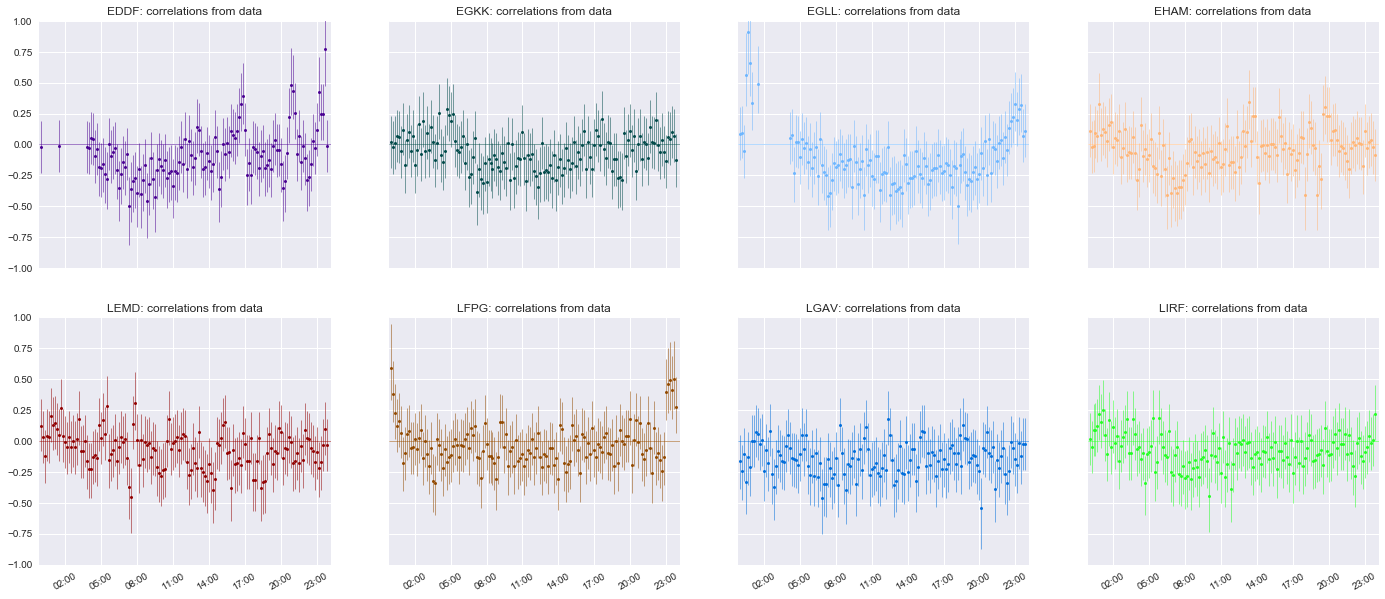

In [66]:
correlations = consecutive_intervals_correlations(m3_bin)
f, axes = plot_correlations(correlations)
f.savefig(os.path.join(IMGFLDR, 'correlations_true.png'), dpi=300, bbox_inches='tight')
foo = correlations_ci_nice_formatter(correlations)
with open(os.path.join(TABFLDR, 'corrM3.tex'), 'w') as ofile:
    ofile.write(foo.to_latex())

### Observed correlations in the *regulated* flight plan

/Users/clancia/anaconda3/envs/interopy/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/clancia/anaconda3/envs/interopy/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


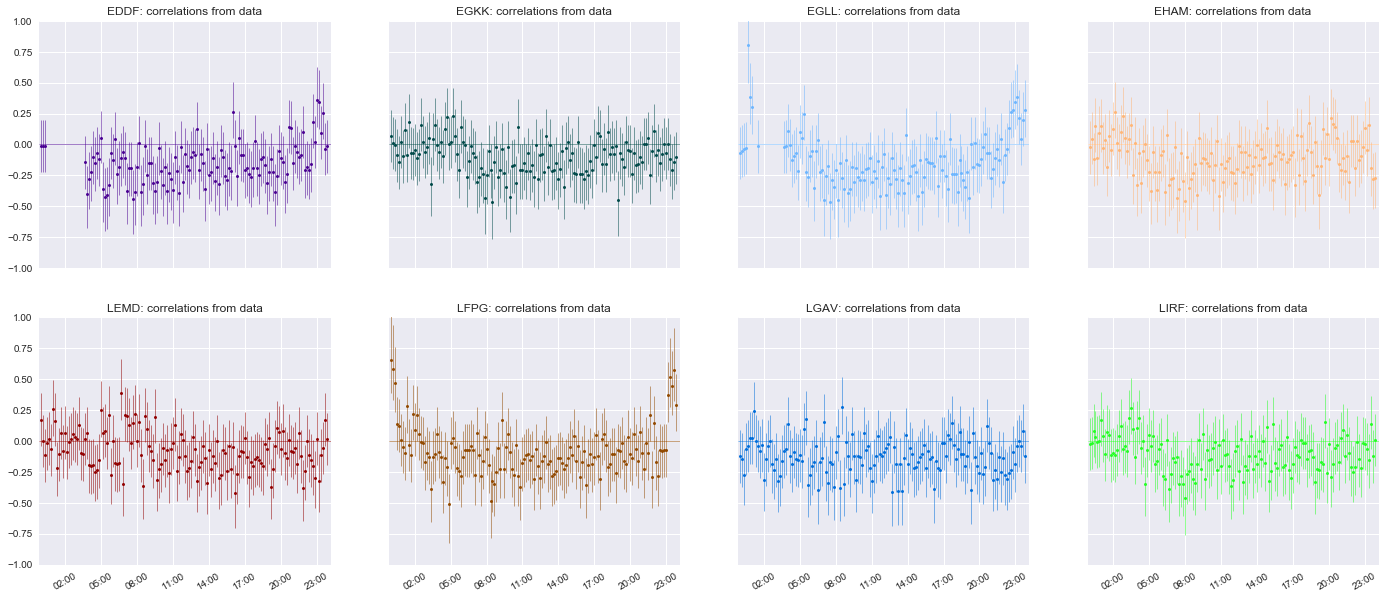

In [67]:
correlations = consecutive_intervals_correlations(m1_bin)
f, axes = plot_correlations(correlations)
f.savefig(os.path.join(IMGFLDR, 'correlations_m1.png'), dpi=300, bbox_inches='tight')
foo = correlations_ci_nice_formatter(correlations)
with open(os.path.join(TABFLDR, 'corrM1.tex'), 'w') as ofile:
    ofile.write(foo.to_latex())

### Correlations from simulations of PSRA

/Users/clancia/anaconda3/envs/interopy/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/clancia/anaconda3/envs/interopy/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


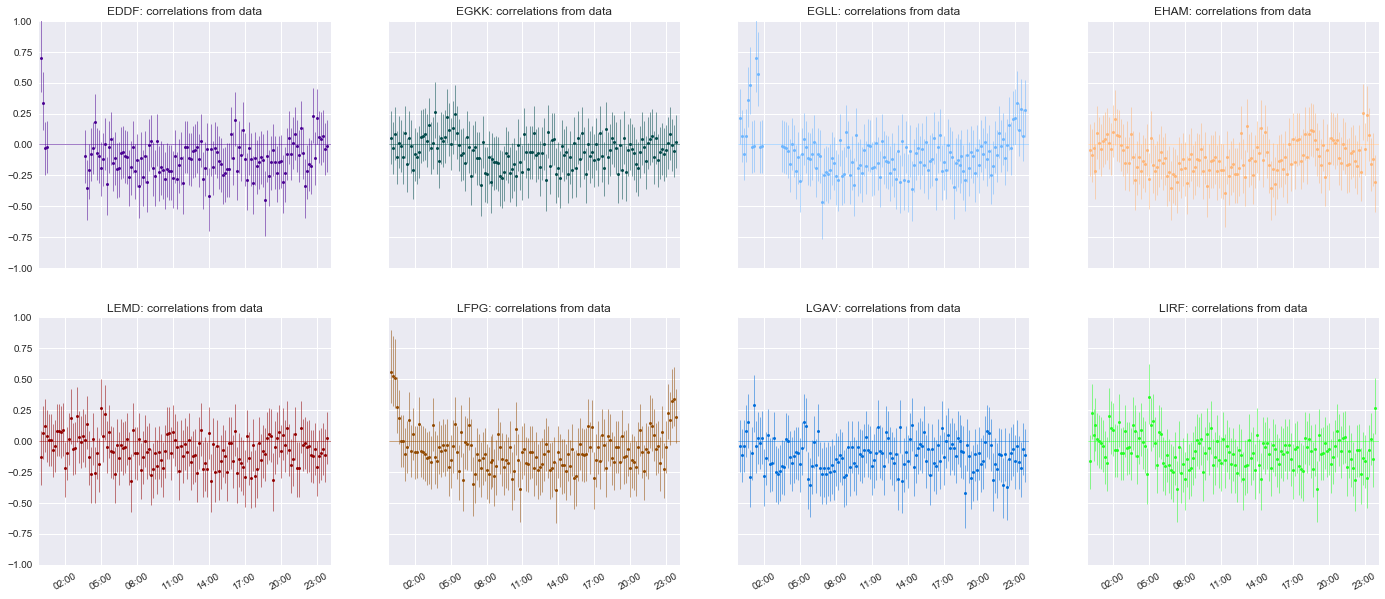

In [68]:
correlations = consecutive_intervals_correlations(psra_bin)
f, axes = plot_correlations(correlations)
f.savefig(os.path.join(IMGFLDR, 'correlations_psra.png'), dpi=300, bbox_inches='tight')
foo = correlations_ci_nice_formatter(correlations)
with open(os.path.join(TABFLDR, 'corrPSRA.tex'), 'w') as ofile:
    ofile.write(foo.to_latex())

In [42]:
for df in dd.values():
    df['national'] = (df['START'].apply(lambda x: x[:2]) == df['END'].apply(lambda x: x[:2])).astype(int)
    df['continental'] = df['START'].apply(lambda x: x[0]).isin(['E', 'L']) * abs(1-df['national'])
    df['intercontinental'] = 1 - df['national'] - df['continental']

In [43]:
dd['EDDF'].head()

,START,END,ID,M1_FL240,M3_FL240,delay,national,continental,intercontinental
0,EDDN,EDDF,197629856,2016-06-15 13:23:40,2016-06-15 13:49:25,00:25:45,1,0,0
1,LEMD,EDDF,197613610,2016-06-15 06:00:45,2016-06-15 06:03:30,00:02:45,0,1,0
2,LDZA,EDDF,197635011,2016-06-15 17:04:02,2016-06-15 17:05:14,00:01:12,0,1,0
3,LPPT,EDDF,197626451,2016-06-15 13:27:49,2016-06-15 14:29:39,01:01:50,0,1,0
4,LSGG,EDDF,197629513,2016-06-15 14:20:59,2016-06-15 15:22:27,01:01:28,0,1,0


# ML-powered PSRA

Here we study the following model for the arrival time of the $i$th aircraft
$$\hat{t}_i^{M3} = t_i^{M1} + \delta(X_i)\,,$$
where $X_i$ is a vector of covariates associated with the delay $\delta = t^{M3} - t^{M1}$.

The vector $X$ contains the following variables: origin (category; national, continental, intercontinental), arrival time accoridng to the M1 flight plan, day of the week, and week number. Both arrival time and week of the year are encoded as two-dimensional cyclic variables using sine/cosine transformations.
The delays $\delta(X_i)$ are modelled using Support Vector Regression.

In [69]:
# time_splits = {
#     # This assumes time in UTC timezone
#     time(4, 0):  0,  # Late Evening/Night
#     time(7, 0):  1,  # Early Morning
#     time(13, 0): 2,  # Late Morning/Early Afternoon
#     time(17, 0): 3   # Late Afternoon/Early Evening
# }


# def categorize_time(time):
#     # Uses the dictionary above to categorize time
#     for ref, lbl in time_splits.items():
#         if ref > time:
#             cat = lbl
#             break
#     else:
#         cat = 0  # Night
#     return cat

In [70]:
def to_seconds(x):
    return x.hour*3600 + x.minute*60 + x.second

In [71]:
onedayinsecs = 24 * 3600
for df in dd.values():
    # df['day_part'] = df['M1_FL240'].dt.time.apply(categorize_time)
    m1_time = to_seconds(df['M1_FL240'].dt)
    df['time_cos'] = np.cos(m1_time*2*np.pi/onedayinsecs)
    df['time_sin'] = np.sin(m1_time*2*np.pi/onedayinsecs)
    weekday = df['M1_FL240'].dt.weekday
    df['weekday_cos'] = np.cos(weekday*2*np.pi/7)
    df['weekday_sin'] = np.sin(weekday*2*np.pi/7)
    df['week'] = df['M1_FL240'].dt.week
    df['dayno'] = df['M1_FL240'].dt.dayofyear
    df['delay_sec'] = df['delay']/pd.Timedelta(1, unit='s')

## Model evaluation via nested cross-validation

In [72]:
def eval_m3_test_pred(model, train_indx, test_indx, df, tz, interval=INTERVAL):
    X_train = df.loc[train_indx, features]
    y_train = np.array(df.loc[train_indx, 'delay_sec'])
    X_test = df.loc[test_indx, features]
    m1_test = df.loc[test_indx, 'M1_FL240']
    m3_test = df.loc[test_indx, 'M3_FL240']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    m3_pred = m1_test + pd.to_timedelta(y_pred, unit='s')
    m3_bin_test = atddm.binarrivals(m3_test,
                                    interval=interval,
                                    tz=tz).fillna(0)
    m3_bin_pred = atddm.binarrivals(m3_pred,
                                    interval=interval,
                                    tz=tz).reindex(index=m3_bin_test.index).fillna(0)
    return (m3_bin_test, m3_bin_pred)

In [73]:
def my_cross_val_scores(rgr, params, scoring, cvsplit, df, tz, interval=INTERVAL):
    scores = {k: [] for k in scoring.keys()}
    for train_indx, test_indx in cvsplit.split(df.index):
        model = rgr(**params)
        m3_bin_test, m3_bin_pred = eval_m3_test_pred(model, train_indx, test_indx, df, tz, interval)
        for k, scr in scoring.items():
            scores[k].append(scr(m3_bin_test, m3_bin_pred))
    return scores

In [74]:
def find_best(cvdf, score='mse', group='icao'):
    foo = cvdf.sort_values([group, score], ascending=False)
    best = foo.groupby(group).first()
    return best

In [75]:
scoring = dict(zip(['r2', 'mse', 'mnae', 'mdae'],
                   [r2_score, 
                    mean_squared_error,
                    mean_absolute_error,
                    median_absolute_error]))
features = ['national', 'continental', 'intercontinental',
            'time_cos', 'time_sin', 'weekday_cos', 'weekday_sin']


In [76]:
def cg_cross_val_score(c, g, scoring, tss, df, tz):
    params = {'kernel': 'rbf', 'C': c, 'gamma': g}
    rgr = SVR
    this_run = my_cross_val_scores(rgr, params, scoring, tss, df, tz)
    return c, g, this_run

### Inner cross validation: choice of parameters

This is slow. The inner round of cross-validation can be skipped if only the next cell is executed.

In [77]:
# Uncomment this to avoid inner cross validation
best_params = pd.DataFrame({'C': [0.01, 0.01, 0.01, 100, 0.01, 1, 0.01, 0.01], 
                            'gamma': [10, 10, 10, 0.1, 1, 10, 10, 10]}, 
                           index=['EDDF', 'EGKK', 'EGLL', 'EHAM', 'LEMD', 'LFPG', 'LGAV', 'LIRF'])
best_params

,C,gamma
EDDF,0.01,10.0
EGKK,0.01,10.0
EGLL,0.01,10.0
EHAM,100.00,0.1
LEMD,0.01,1.0
LFPG,1.00,10.0
LGAV,0.01,10.0
LIRF,0.01,10.0


In [ ]:
ncores = 3
pool = mp.Pool(processes=ncores)

In [ ]:
# WARNING: this is slow
ns = 2
tss = TimeSeriesSplit(n_splits=ns)
C_range = np.logspace(-2, 2, 3)
gamma_range = np.logspace(-1, 1, 3)
parmvec = np.array(np.meshgrid(C_range, gamma_range)).T.reshape(-1,2)
cvdf = pd.DataFrame()
for code in CODES:
    print('Tuning parameters of {:s}'.format(code))
    results = [pool.apply_async(cg_cross_val_score, 
                                args=(c,g,scoring,tss,dd[code],TZONES[code])) 
               for c,g in parmvec]
    for p in results:
        c, g, this_run = p.get()
        params = {'kernel': 'rbf', 'C': c, 'gamma': g}
        this_run_mean = {k: np.mean(a) for k, a in this_run.items()}
        cvdf = cvdf.append(pd.Series({**{'icao': code}, **params, **this_run_mean}),ignore_index=True)

In [ ]:
pool.terminate()
pool.join()

In [ ]:
# # WARNING: this is slow
# ns = 2
# tss = TimeSeriesSplit(n_splits=ns)
# C_range = np.logspace(-2, 2, 3)
# gamma_range = np.logspace(-1, 1, 3)
# parmvec = np.array(np.meshgrid(C_range, gamma_range)).T.reshape(-1,2)
# cvdf = pd.DataFrame()
# for code in CODES:
#     print('Tuning parameters of {:s}'.format(code))
#     for c, g in parmvec:
#         print(c, g)
#         params = {'kernel': 'rbf', 'C': c, 'gamma': g}
#         rgr = SVR
#         this_run = my_cross_val_scores(rgr, params, scoring, tss, dd[code], TZONES[code])
#         this_run_mean = {k: np.mean(a) for k, a in this_run.items()}
#         cvdf = cvdf.append(pd.Series({**{'icao': code}, **params, **this_run_mean}),ignore_index=True)

In [ ]:
best_params = find_best(cvdf)

In [ ]:
best_params

### Outer cross validation: model evaluation

In [ ]:
def code_cross_val_scores(code, best_params, param_lbls, scoring, tss, df, tz):
    bp = best_params.loc[code, param_lbls].tolist()
    params = dict(zip(param_lbls, bp))
    svr = SVR
    cv_scores = my_cross_val_scores(svr, params, scoring, tss, df, tz)
    return code, cv_scores

In [ ]:
ncores = 3
pool = mp.Pool(processes=ncores)

In [ ]:
# WARNING: this is slow
scores = {}
ns = 12
tss = TimeSeriesSplit(n_splits=ns)
param_lbls = ['C', 'gamma']
results = [pool.apply_async(code_cross_val_scores,
                            args=(code, best_params, param_lbls, scoring,
                                  tss, dd[code], TZONES[code]))
           for code in CODES]
for p in results:
    code, cv_scores = p.get()
    scores[code] = cv_scores

In [ ]:
pool.terminate()
pool.join()

In [ ]:
# # WARNING: this is slow
# scores = {}
# ns = 12
# tss = TimeSeriesSplit(n_splits=ns)
# param_lbls = ['C', 'gamma']
# for code in CODES:
#     print('Cross-validation for {:s}'.format(code))
#     bp = best_params.loc[code, param_lbls].tolist()
#     params = dict(zip(param_lbls, bp))
#     svr = SVR
#     cv_scores = my_cross_val_scores(rgr, params, scoring, tss, dd[code], TZONES[code])
#     scores[code] = cv_scores

In [ ]:
k = 'EDDF'
list(scores[k].items())

In [ ]:
mean_scores = {}
for key in scores.keys():
    mean_scores[key] = {k: np.mean(v) for k, v in scores[key].items()}

In [ ]:
crossvaldf = pd.DataFrame(mean_scores).T
crossvaldf

In [ ]:
# # delete later
# param_lbls = ['C', 'gamma']

## Performance

In [ ]:
ncores = 3
pool = mp.Pool(processes=ncores)

In [ ]:
def code_predict(code, trgtweek, best_params, param_lbls, df, tz, interval=INTERVAL):
    train_indx = df.loc[df['week'] < trgtweek].index
    test_indx = df.loc[df['week'] >= trgtweek].index
    bp = best_params.loc[code, param_lbls].tolist()
    params = dict(zip(param_lbls, bp))
    model = SVR(**params)
    m3_bin_test, m3_bin_pred = eval_m3_test_pred(model, train_indx, test_indx, df, tz, interval)
    return code, m3_bin_test, m3_bin_pred

In [ ]:
lastweek = 36 # September 5-11, 2016
pred = {}
results = [pool.apply_async(code_predict, 
                            args=(code, lastweek, best_params,
                                  param_lbls, dd[code], TZONES[code]))
           for code in CODES]
for p in results:
    code, m3_bin_test, m3_bin_pred = p.get()
    pred[code] = {'true': m3_bin_test, 'pred_psra': m3_bin_pred}

In [ ]:
pool.terminate()
pool.join()

In [ ]:
# lastweek = 36 # September 5-11, 2016
# pred = {}
# for code in CODES:
#     print('Predicting now {:s}'.format(code))
#     foo = dd[code]
#     tz = TZONES[code]
#     train_indx = foo.loc[foo['week'] < lastweek].index
#     test_indx = foo.loc[foo['week'] >= lastweek].index
#     bp = best_params.loc[code, param_lbls].tolist()
#     params = dict(zip(param_lbls, bp))
#     model = SVR(**params)
#     m3_bin_test, m3_bin_pred = eval_m3_test_pred(model, train_indx, test_indx, foo, tz)
#     pred[code] = {'true': m3_bin_test, 'pred_psra': m3_bin_pred}

### Last week

In [ ]:
f, axes = plt.subplots(NX, NY, sharex=True, sharey=True, figsize=(SX, SY))
xx = range(24*60//freq)
for ax, code in zip(axes.flatten(), CODES):
    indx = pd.date_range('2016-09-05', periods=144*7, freq='10T', tz=TZONES[code])
    kolor = rgbfy(code)
    true_mean = atddm.daily_avg(pred[code]['true'], tz=TZONES[code])
    pred_mean = atddm.daily_avg(pred[code]['pred_psra'], tz=TZONES[code])
    ### Poisson
    xval = [0] + [timetofloat(tpl[1], freq) for tpl in airp_parm[code]] +\
        [24*60//freq]
    yval = [tpl[0]*freq for tpl in airp_parm[code]]
    yval = [yval[-1], yval[-1]] + yval
    # this is needed to plot the demamd estimated by Poisson
    # correctly at the beginning and the end of the day
    # and in such a way that the process is 24-hour periodic
    pois_mean = [np.mean(stats.poisson.rvs(yval[bisect(xval, x)], size=7)) for x in xx]
    ###
    ax.plot(range(24*60//freq),
            true_mean['mu']-pred_mean['mu'],
            c=kolor,
            linestyle='-',
            alpha=0.7,
            label='PSRA')
    ax.plot(range(24*60//freq),
            np.array(true_mean['mu']) - np.array(pois_mean),
            c=kolor,
            linestyle=':',
            alpha=0.7,
            label='Poisson')
    legend = ax.legend(loc='upper left')
    ax.set_title(axtitle(code))
ax.set_xlim(0, 24*60//freq)
ax.set_xticks(xticks)
ax.set_xticklabels([times[i] for i in xticks])
for ax in axes[:, 0]:
    ax.set_ylabel('Demand aggregated by {:d} mins'.format(INTERVAL))
for ax in axes[-1]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
f.suptitle('Difference between true and predicted demand on 2016-09-05/11 aggregated by {:d} mins'.format(INTERVAL))
f.savefig(os.path.join(IMGFLDR, 'prediction_last_week.png'), dpi=300, bbox_inches='tight')
plt.show()

### Last day

In [ ]:
f, axes = plt.subplots(NX, NY, sharex=True, sharey=True, figsize=(SX, SY))
xx = range(24*60//freq)
for ax, code in zip(axes.flatten(), CODES):
    indx = pd.date_range('2016-09-15', periods=144, freq='10T', tz=TZONES[code])
    kolor = rgbfy(code)
    ts = pred[code]['true'].reindex(indx).fillna(0) -\
         pred[code]['pred_psra'].reindex(indx).fillna(0)
    ax.plot(range(24*60//freq),
            np.array(ts),
            c=kolor,
            linestyle='-',
            linewidth=LW,
            alpha=0.7,
            label='PSRA')
    
    xval = [0] + [timetofloat(tpl[1], freq) for tpl in airp_parm[code]] +\
        [24*60//freq]
    yval = [tpl[0]*freq for tpl in airp_parm[code]]
    yval = [yval[-1], yval[-1]] + yval
    # this is needed to plot the demamd estimated by Poisson
    # correctly at the beginning and the end of the day
    # and in such a way that the process is 24-hour periodic
    yy = [stats.poisson.rvs(yval[bisect(xval, x)]) for x in xx]
    ts = np.array(pred[code]['true'].reindex(indx).fillna(0)) -\
         np.array(yy)
    ax.plot(range(24*60//freq),
            ts,
            c=kolor,
            linestyle=':',
            linewidth=LW,
            alpha=0.7,
            label='Poisson')
    
    ax.set_title(axtitle(code))
    legend = ax.legend(loc='upper left')
ax.set_xlim(0, 24*60//freq)
ax.set_xticks(xticks)
ax.set_xticklabels([times[i] for i in xticks])
for ax in axes[:, 0]:
    ax.set_ylabel('Differenced demand')
for ax in axes[-1]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
f.suptitle('Difference between true and predicted demand on 2016-09-14 aggregated by {:d} mins'.format(INTERVAL))
f.savefig(os.path.join(IMGFLDR, 'prediction_last_day.png'), dpi=300, bbox_inches='tight')
plt.show()